# NLP with RNNs without embeddings
* Notebook by Adam Lang
* Date: 5/24/2024
* In this notebook we will go over the architecture and use cases for recurrent neural networks. We will also cover GRUs and LSTMs but in another notebook.
* It should be noted that in this notebook we will demo an RNN without using word embeddings to show the weakness of vectorizing words and sentences and feeding them into an RNN without using embeddings.

# RNNs Overview
* RNNs process text sequeces 1 time step at a time.
  * Each word is 1 step.
  * Example:
  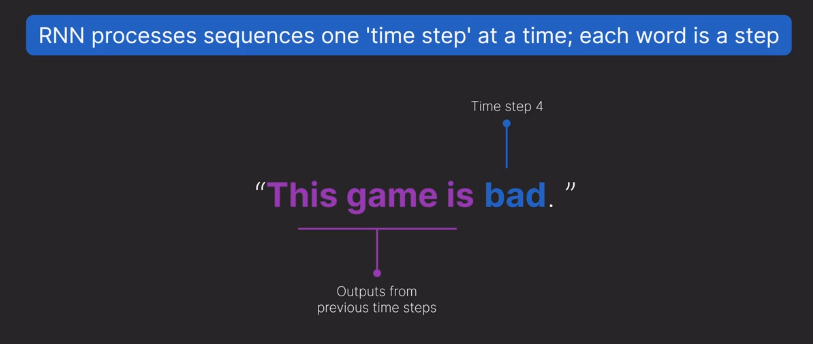

* Contextual understanding is obtained

## RNN nuts and bolts
* input layer -> hidden layer -> output layer
* RNNs take information from the previous timestep.
* Hidden states capture vectors at each time step.
* Weights remain the same during forward propagation.
* All weights and biases are matrices not scalars.
* Forward propagation in RNN:
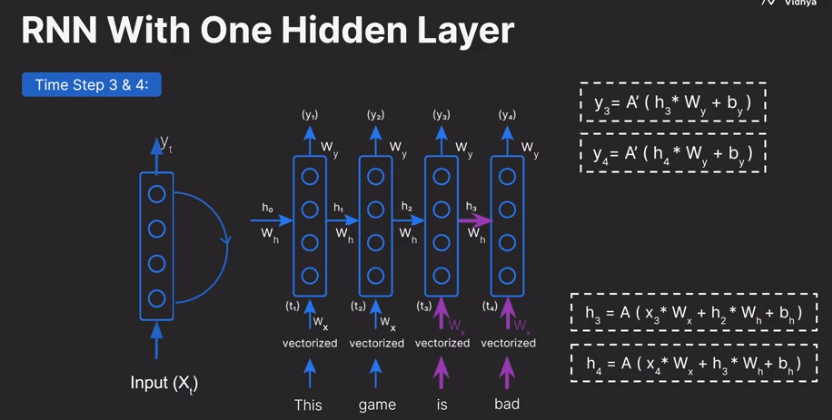


## Backpropagation in RNNs
* Input -> forward prop -> hidden layer -> output
* Backpropagation is similar in ANNs.
* Goal is to optimize network weights by minimizing the loss function.
  * Weights and biases are updated.
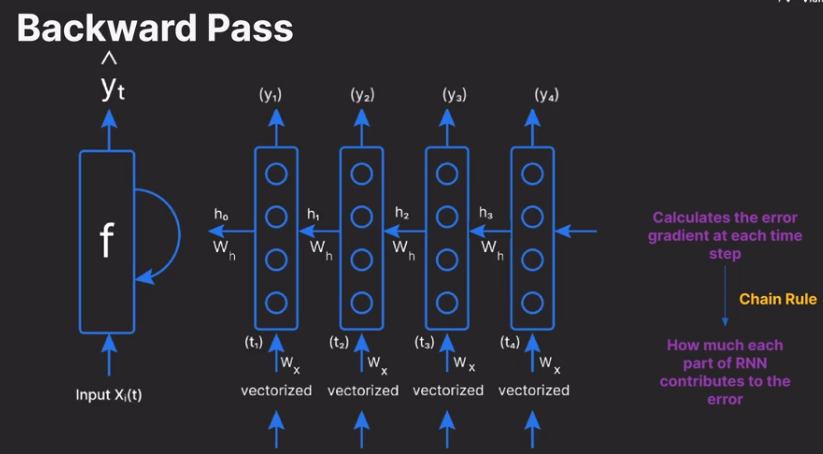

## 4 types of RNN Architectures
1. Many to One
* input is an entire sentence or time series --> this is also the output
  * input: sequential data
  * output: non sequential data
  * Example use cases:
      * sentiment analysis
      * pixel games


2. Many to Many
* Two types of these exist
    * 1. len input sequence == len output sequence
        * Examples:
            * Part of speech tagging
            * Named entity recognition (NER)
    * 2. len input sequence != len output sequence
        * Examples:
            * Machine Translation

3. One to Many
    * Non sequential data input --> sequential data output
        * Example:
            * image captioning
            * music generation

4. One to One
    * non sequential input and output
    * simple ANN architecture!

# Build RNN with Word Indexing

In [8]:
# import libraries
import nltk
nltk.download('punkt')
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score

# PyTorch imports
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Check if CUDA-enabled GPU is present

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# datasets
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/Text_Classification/Building a Classification Model/NLP_Classification_Modeling/train.csv')
validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/Text_Classification/Building a Classification Model/NLP_Classification_Modeling/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/Text_Classification/Building a Classification Model/NLP_Classification_Modeling/test.csv')

In [5]:
# print the shapes
print(f"Train data shape: {train.shape}")
print(f"Validation data shape: {validation.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (17877, 5)
Validation data shape: (3831, 5)
Test data shape: (3831, 5)


## Pre-processing text

In [9]:
# function to pre-process text
import re

def preprocess_text(text):
  """This Function checks if text is a string,
  keeps only letters and white spaces, converts text to lowercase,
  and tokenizes the text."""
  # check if text is a string
  if not isinstance(text, str):
    return []

  # keep only letters and whitespaces
  pattern = f"[a-zA-Z\s]"
  text = ''.join(re.findall(pattern, text))

  # convert to lowercase
  text = text.lower()

  # tokenize the text
  tokens = nltk.word_tokenize(text)
  # tokens = ''.join(tokens)

  return tokens

In [10]:
# apply functio to preprocess text
train['user_review'] = train['user_review'].apply(preprocess_text)
validation['user_review'] = validation['user_review'].apply(preprocess_text)
test['user_review'] = test['user_review'].apply(preprocess_text)

In [11]:
# check the head of train data
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0


We have been able to preprocess the text.

## Build Vocabulary

In [12]:
## define a function to do this
def build_vocabulary(reviews):
  """This function encodes the tokenized text."""
  vocab = {}
  index = 1 #start indexing from 1; reserve 0 for padding
  for review in reviews:
    for word in review:
      if word not in vocab:
        vocab[word] = index
        index += 1
  return vocab

## Concatenate all user reviews to build the vocabulary

In [13]:
## concatenate all reviews to build vocabulary
all_reviews = train['user_review'].tolist() + validation['user_review'].tolist() + test['user_review'].tolist()
vocab = build_vocabulary(all_reviews)
print("Vocabulary length:", len(vocab))
first_50 = list(vocab.items())[:50]
for key, value in first_50:
  print(f'{key}: {value}')

Vocabulary length: 104326
early: 1
access: 2
reviewvery: 3
great: 4
shooter: 5
that: 6
have: 7
originality: 8
in: 9
it: 10
but: 11
of: 12
course: 13
some: 14
newbies: 15
dont: 16
understand: 17
mechanic: 18
shooting: 19
which: 20
guns: 21
is: 22
same: 23
or: 24
not: 25
throught: 26
visual: 27
look: 28
and: 29
what: 30
to: 31
do: 32
rankedbut: 33
theres: 34
thing: 35
keeps: 36
me: 37
think: 38
how: 39
would: 40
game: 41
evolve: 42
sure: 43
its: 44
still: 45
i: 46
developers: 47
need: 48
speed: 49
up: 50


## Zero padding
* Zero padding is beneficial in maintaining a consistent length of input sequences for the model. Zero index is used to fill empty space to maintain a uniform length for all sequences.
* Example: len of 80, last 20 will fill with zero padding.

In [15]:
## index reviews based on vocab
def index_and_pad_reviews(reviews, vocab, max_length=100):
  """Index and pad tokenized reviews to a fixed length."""
  indexed_reviews = []
  for review in reviews:
    indexed_review = [vocab.get(word, 0) for word in review] # use vocab.get to handle uknown words
    # truncate if review length exceeds max_length
    truncated_review = indexed_review[:max_length]
    # pad review with zeros if it's shorter than max_length
    padded_review = truncated_review + [0] * (max_length - len(truncated_review))
    indexed_reviews.append(padded_review)
  return indexed_reviews

In [16]:
## convert df to list
train_review = train['user_review'].tolist()
test_review = test['user_review'].tolist()
validation_review = validation['user_review'].tolist()

In [17]:
## index and pad reviews for each set
train_indexed = index_and_pad_reviews(train_review, vocab)
test_indexed = index_and_pad_reviews(test_review, vocab)
validation_indexed = index_and_pad_reviews(validation_review, vocab)

In [18]:
# convert indexed reviews back to DataFrame for further use
train['user_review_indexed'] = train_indexed
test['user_review_indexed'] = test_indexed
validation['user_review_indexed'] = validation_indexed

In [19]:
## view train head
train.head()

,review_id,title,year,user_review,user_suggestion,user_review_indexed
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1,"[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 1..."
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1,"[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58,..."
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1,"[126, 127, 128, 41, 129, 31, 130, 131, 132, 9,..."
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0,"[57, 41, 58, 159, 160, 161, 71, 81, 162, 82, 1..."


In [20]:
## view a few reviews and indexes
for i in range(3):
  print(train.user_review[i], '\n')

['early', 'access', 'reviewvery', 'great', 'shooter', 'that', 'have', 'originality', 'in', 'it', 'but', 'of', 'course', 'some', 'newbies', 'dont', 'understand', 'mechanic', 'of', 'shooting', 'which', 'guns', 'is', 'same', 'or', 'not', 'throught', 'visual', 'look', 'and', 'what', 'to', 'do', 'in', 'rankedbut', 'theres', 'thing', 'that', 'keeps', 'me', 'think', 'how', 'would', 'game', 'evolve', 'sure', 'its', 'still', 'in', 'early', 'access', 'but', 'i', 'think', 'developers', 'need', 'to', 'speed', 'up', 'process', 'of', 'finishing', 'game', 'cuz', 'still', 'comparing', 'to', 'other', 'games', 'this', 'game', 'has', 'low', 'number', 'of', 'community', 'and', 'some', 'things', 'that', 'makes', 'player', 'think', 'that', 'black', 'squad', 'is', 'another', 'copy', 'of', 'csgo', 'and', 'he', 'would', 'not', 'download', 'iti', 'hope', 'you', 'understand', 'my', 'message', 'i', 'really', 'like', 'this', 'game', 'but', 'i', 'dont', 'think', 'it', 'can', 'keep', 'me', 'for', 'a', 'year'] 

['i'

In [21]:
## view another one
for i in range(3):
  print(train_indexed[:3][i], '\n')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 33, 34, 35, 6, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 9, 1, 2, 11, 46, 38, 47, 48, 31, 49, 50, 51, 12, 52, 41, 53, 45, 54, 31, 55, 56, 57, 41, 58, 59, 60, 12, 61, 29, 14, 62, 6, 63, 64, 38, 6, 65, 66, 22, 67, 68, 12, 69, 29, 70, 40, 25, 71, 72, 73, 74, 17] 

[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 12, 88, 31, 89, 90, 74, 91, 25, 92, 93, 94, 95, 96, 29, 97, 98, 99, 22, 100, 101, 84, 31, 57, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58, 106, 82, 107, 41, 100, 108, 109, 97, 110, 111, 29, 112, 113, 114, 115, 116, 117, 82, 118, 119, 120, 9, 121, 74, 122, 123, 10, 124, 125, 4, 41, 81, 30, 10, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Create PyTorch Tensors

In [22]:
## function for tensors
def prepare_data(reviews, labels):
  """Function creates PyTorch tensors"""
  # convert pre-padded reviews into a tensor
  X = torch.tensor(reviews, dtype=torch.float)

  # convert labels into a tensor
  y = torch.tensor(labels, dtype=torch.float)

  return X, y

## Prepare data for DataLoader

In [23]:
## prep data
X_train, y_train = prepare_data(train['user_review_indexed'], train['user_suggestion'])

X_val, y_val = prepare_data(validation['user_review_indexed'], validation['user_suggestion'])


## Create DataLoader

In [24]:
## DataLoader
batch_size = 64
train_data = TensorDataset(X_train, y_train)
## use batch_size and shuffle data for randomness
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [25]:
## create validation dataloader
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)


## RNN Model with Word Indexing
* Hyperparameters defined for the RNN.
* We can finetune these as needed.

In [26]:
## hyperparameters for RNN
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 30

In [27]:
## Build Classes
class SentimentRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(SentimentRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # Basic RNN layer without dropout layer
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.tanh = nn.Tanh() # Tanh activation layer
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid() # Sigmoid activation layer

  def forward(self, x):
    # initial hidden layer
    h0 =  torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    # RNN output
    out, _ = self.rnn(x, h0)
    # apply Tanh to outputs of RNN layer
    out = self.tanh(out)
    # get last sequence output for classification
    out = out[:, -1, :]
    # apply linear layer for final output
    out = self.fc(out)
    # apply sigmoid activation
    out = self.sigmoid(out)
    return out



## set loss function and optimizer

In [28]:
## init model, loss funct and optimizzer
model = SentimentRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Calculate Accuracy Function

In [29]:
def calculate_accuracy(loader):
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.unsqueeze(-1).float()
      outputs = model(inputs)
      predicted = outputs.squeeze() > 0.5
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

## Training loop

Epoch 1/30, Loss: 0.6845, Val Loss: 0.6842
Epoch 2/30, Loss: 0.6841, Val Loss: 0.6849
Epoch 3/30, Loss: 0.6834, Val Loss: 0.6835
Epoch 4/30, Loss: 0.6850, Val Loss: 0.6846
Epoch 5/30, Loss: 0.6838, Val Loss: 0.6832
Epoch 6/30, Loss: 0.6839, Val Loss: 0.6832
Epoch 7/30, Loss: 0.6844, Val Loss: 0.6864
Epoch 8/30, Loss: 0.6841, Val Loss: 0.6857
Epoch 9/30, Loss: 0.6840, Val Loss: 0.6841
Epoch 10/30, Loss: 0.6841, Val Loss: 0.6835
Epoch 11/30, Loss: 0.6838, Val Loss: 0.6861
Epoch 12/30, Loss: 0.6838, Val Loss: 0.6869
Epoch 13/30, Loss: 0.6839, Val Loss: 0.6850
Epoch 14/30, Loss: 0.6840, Val Loss: 0.6860
Epoch 15/30, Loss: 0.6835, Val Loss: 0.6843
Epoch 16/30, Loss: 0.6833, Val Loss: 0.6871
Epoch 17/30, Loss: 0.6836, Val Loss: 0.6856
Epoch 18/30, Loss: 0.6838, Val Loss: 0.6841
Epoch 19/30, Loss: 0.6842, Val Loss: 0.6860
Epoch 20/30, Loss: 0.6837, Val Loss: 0.6855
Epoch 21/30, Loss: 0.6834, Val Loss: 0.6844
Epoch 22/30, Loss: 0.6838, Val Loss: 0.6852
Epoch 23/30, Loss: 0.6847, Val Loss: 0.68

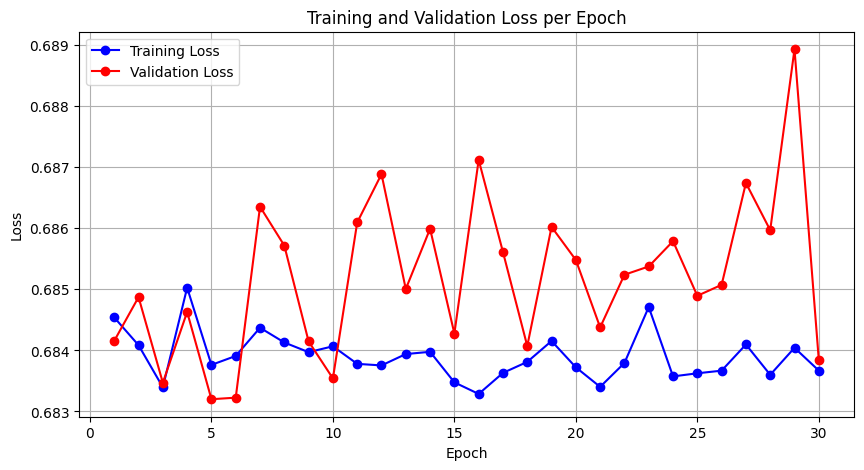

Best Model Training Accuracy: 56.732113889355034%
Best Model Validation Accuracy: 56.8780997128687%


In [33]:
#Training loop
import matplotlib.pyplot as plt
%matplotlib inline
#from tqdm import tqdm

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss

# training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(-1).float()
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')

    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_indexing_best_model.pth')  # Save the best model

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_indexing_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')


# Summary
* We can see this model performed very poorly and underfit the training data (overall). Although the lowest validation loss was at epoch 5, this trend did not continue and the validation loss continued to increase showing the underfitting of the data.
* This is because we did not utilize an optimal vectorization method for our text during the pre-processing phase.
* We will look at in another notebook how using word embeddings can and will improve the outcome of this RNN model.